# MiniHack The Planet - Advantage Actor Critic

**Table of Contents**
1. Helper Functions
2. Advantage Actor Critic (A2C) Model 
3. A2C Algorithm 
4. A2C Evaluation <br>
    4.1  A2C Learning Simple Navigation Task (_Room 5x5 Environment_) <br>
    4.2 A2C Learning Simple Skill Acquisition Task (_Eat Environment_) <br>
    4.3 A2C Performance on _Quest-Hard Environment_

In [8]:
import numpy as np 
import gym
import minihack 
from nle import nethack 

import numpy as np 
import random
import matplotlib.pyplot as plt 
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import flatten

from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Helper Functions

In [10]:
def moving_average(a, n):
    """Calculates the moving average of an array a with a window size n"""
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

In [11]:
def display_screen(state):
    """Displays the state as the screen in image form using the 'pixel' observation key"""
    screen = Image.fromarray(np.uint8(state['pixel']))
    display(screen)

In [12]:
def format_state(state):
    """Formats the state according to the input requirements of the Actor Critic Neural Network"""
    
    # Normalize and reshape for convolutional layer input
    glyphs = state["glyphs"]
    glyphs = glyphs/glyphs.max()
    glyphs = glyphs.reshape((1,1,21,79))
    
    # Normalize the message and reshape for the fully connected layer input 
    message = state["message"]
    if state["message"].max()>0: 
        # Occassionally the message is empty which will cause a Zero Division error 
        message = message/message.max()
    message = message.reshape((1,len(message)))
    
    state = {"glyphs":glyphs,"message":message}
    return state

In [13]:
def compute_returns(rewards, gamma):
    """Computes the discounted returns of a sequence of rewards achieved in a trajectory"""
    returns = []
    r= 0
    for reward in rewards[::-1]:
        r = reward + gamma*r
        returns.append(r)
    returns.reverse()
    returns = np.array(returns)
    
    # Standardize Returns 
    if np.mean(returns)!= 0:
         returns = returns - np.mean(returns)
    if np.std(returns) != 0:
        returns = returns/ np.std(returns)

    return returns

In [36]:
def plot_results(env_name,scores, color,ylim):
    """Plots the reward attained by an Agent at each step of training in 
        an environment for each iteration and average over all iterations"""
    
    plt.figure(figsize=(8,6))
    
    # Plot individual iterations 
    for score in scores:
        plt.plot(score, alpha =0.1, color=color)
    
    # Plot mean over all iterations
    mean = np.mean(scores,axis=0)
    plt.plot(mean, color=color,label="Mean Reward")
    
    plt.title(f"Actor Critic - {env_name}")
    plt.xlabel("Episode Number")
    plt.ylabel("Reward")
    plt.yticks(np.arange(ylim[0], ylim[1], 1.00))
    plt.legend(loc=4)
    plt.savefig(f"Actor-Critic-{env_name}.pdf")
    plt.show()

## 2. Advantage Actor Critic (A2C) Model 

In [15]:
class ActorCritic(nn.Module):
    """The Actor Critic Neural Network used to estimate the state value function and action probabilities"""
    def __init__(self,s_size=8,h_size=128, a_size=4):
        
        # The network architecture follows the popular lenet-5 CNN architeture 
        super(ActorCritic, self).__init__()
        
        # Initialize first set of convolutional and pooling layers with a ReLU activation function 
        self.conv1 = Conv2d(in_channels=1, out_channels=20,
                            kernel_size=(5, 5))
        self.relu1 = ReLU()
        self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        
        # Initialize second set of of convolutional and pooling layers with a ReLU activation function 
        self.conv2 = Conv2d(in_channels=20, out_channels=50,
                            kernel_size=(5, 5))
        self.relu2 = ReLU()
        self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        
        # Initialize fully connected layers for glyph output after convolutional and pooling layers
        self.fc1 = Linear(in_features=1600, out_features=500)
        self.relu3 = ReLU()
        self.fc2 = Linear(in_features=500, out_features=128)
        self.relu4 = ReLU()
        
        # Initialize fully connected for message input 
        self.fc3 = Linear(in_features=256, out_features=128)
        self.relu5 = ReLU()
        
        # Initialize fully connected for combination of glyphs and message 
        self.fc4 = Linear(in_features=256, out_features=128)
        self.relu6 = ReLU()

        # To estimate the value function of the state 
        self.value_layer = nn.Linear(128, 1)

        # To calculate the probability of taking each action in the given state
        self.action_layer = nn.Linear(128, a_size)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, state):
        
        # Transform the glyph and state arrays into tensors 
        glyphs_t  = torch.from_numpy(state["glyphs"]).float().to(device)
        message_t  = torch.from_numpy(state["message"]).float().to(device)

        # Pass the 2D glyphs input through our convolutional and pooling layers 
        glyphs_t = self.conv1(glyphs_t)
        glyphs_t = self.relu1(glyphs_t)
        glyphs_t = self.maxpool1(glyphs_t)
        glyphs_t = self.conv2(glyphs_t)
        glyphs_t = self.relu2(glyphs_t)
        glyphs_t = self.maxpool2(glyphs_t)
        
        # Platten the output from the final pooling layer and pass it through the fully connected layers 
        glyphs_t = glyphs_t.reshape(glyphs_t.shape[0], -1)
        glyphs_t = self.fc1(glyphs_t)
        glyphs_t = self.relu3(glyphs_t)
        glyphs_t = self.fc2(glyphs_t)
        glyphs_t = self.relu4(glyphs_t)
        
        # Pass the message input through a fully connected layer
        message_t = self.fc3(message_t)
        message_t = self.relu5(message_t)
        
        # Combine glyphs output from convolution and fully connected layers 
        # with message output from fully connected layer 
        # Cat and Concat are used for different versions of PyTorch
        try:
            combined = torch.cat((glyphs_t,message_t),1)
        except:
            combined = torch.concat([glyphs_t,message_t],1)

        # Pass glyphs and messaged combination through a fully connected layer
        combined = self.fc4(combined)
        combined = self.relu6(combined)
        
        # Pass the output from the previous fully connected layer through two seperate 
        # fully connected layers, one with a single output neuron (to estimate the state value function)
        # and the other with the number of output neurons equal to the number of actions 
        # (to estimate the action probabilities)
        state_value = self.value_layer(combined)
        
        action_probs = self.action_layer(combined)
        action_probs = self.softmax(action_probs)
        
        return action_probs,state_value

## 3. A2C Algorithm 

In [39]:
def actor_critic(env, model, seed, learning_rate, number_episodes, max_episode_length, gamma, verbose=True):
    """
    Method to train Actor Critic model.
    
    Input:
    env: The environment to be used during training
    seed: The random seed for any random operations performed 
    learning_rate: The learning rate uesd for the Adam optimizer when training the model 
    number_episodes: Number of episodes to train for 
    max_episode_length: The maximum number of steps to take in an episode before terminating
    gamma: The discount factor used when calculating the discounted rewards of an episode
    verbose: Print episode reward after each episode
    
    Returns:
    policy: The neural network model after training that approximates the state value functions and action probabilities
    scores: The cumulative reward achieved by the agent for each episode during traiing
    """
    # Setting random seeds (for reproducibility)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    env.seed(seed)
    
    # Initialize optimizer for Actor Critic Network
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # List to store the rewards attained in each episode 
    scores =[]
    
    for i in range(number_episodes):
        # Reset environment
        state = format_state(env.reset())
        # Flag to see if episode has terminated
        done = False
        
        # Lists to store the rewards acquired, the log_probability of the actions and
        # the value function of the states visited in this episode 
        rewards = []
        log_probs = []
        state_values = []
        
        for t in range(1, max_episode_length):
            
            # Get the probability distribution over actions and 
            # estimated state value function from Actor Critic network 
            action_probs,state_value = model.forward(state)
            distribution = torch.distributions.Categorical(action_probs)
            # Sample from the probability distribution to determine which action to take 
            action = distribution.sample()
            
            # Take selected action, observe the reward received, the next state 
            # and whether or not the episode terminated 
            next_state, reward, done, _ = env.step(action.item())
            next_state = format_state(next_state)
    
            # Store the reward, log of the probability of the action selected 
            # And
            rewards.append(reward)
            log_probs.append(distribution.log_prob(action))
            state_values.append(state_value)
            
            state = next_state
            
            if done:
                break
        
        # Store the reward acquired in the episode and calculate the discounted return of the episode
        scores.append(np.sum(rewards))
        returns = compute_returns(rewards, gamma)
        returns = torch.from_numpy(returns).float().to(device)
        
        # Print the episode, the reward acquired in the episode and the mean reward over the last 50 episodes 
        if verbose:
            print("Episode:",i,"Reward:",np.sum(rewards),"Average Reward:",np.mean(scores[-50:]),"Steps",t)
        
        # Calculate the loss for the episode and use it to update the network parameters 
        loss = 0
        for logprob, value, reward in zip(log_probs, state_values, returns):
            advantage = reward  - value.item()
            action_loss = -logprob * advantage
            try:
                reward = reward.resize(1,1)
            except:pass
            value_loss = F.smooth_l1_loss(value, reward)
            loss += (action_loss + value_loss)   
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 
        
    # Store the policy as the neural network model at the final iteration 
    policy = model

    return policy, scores

In [40]:
def run_actor_critic(env,number_episodes,max_episode_length,iterations):
    """Trains Actor Critic model for a number of episodes on a given environment"""
    seeds = np.random.randint(1000, size=iterations)
    scores_arr = [] 
    
    for seed in seeds:
        # Initialize the Actor Critic Model 
        ac_model = ActorCritic(h_size=512, a_size=env.action_space.n)

        # Train the Actor Critic Model 
        policy, scores = actor_critic(env=env,
                                    model= ac_model, 
                                    seed=seed, 
                                    learning_rate=0.02,
                                    number_episodes=number_episodes, 
                                    max_episode_length=max_episode_length, 
                                    gamma=0.99 ,
                                    verbose=True)
        
        # Store rewards for this iteration 
        scores_arr.append(scores)
        
    return scores_arr

## 4. Evaluation

## 4.1 Navigation - Room 5x5 

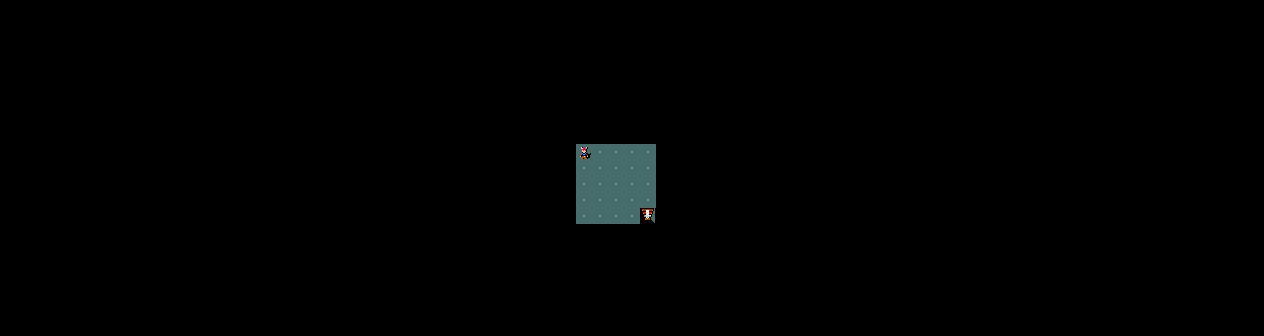

In [41]:
# Create the environment with the observations keys required as input to the Actor Critic Neural Network 
# The max number of epsidoe steps for the environment needs to be increased as it defaults to 250 for Navigation tasks
env = gym.make("MiniHack-Room-5x5-v0", observation_keys=["glyphs","pixel","message"],max_episode_steps=1000)

# Reset the environment and display the screen of the starting state 
display_screen(env.reset())

In [42]:
room_5x5_scores = run_actor_critic(env,number_episodes=100,max_episode_length=1000,iterations=5)

Episode: 0 Reward: 0.9 Average Reward: 0.9 Steps 28
Episode: 1 Reward: 1.0 Average Reward: 0.95 Steps 4


/opt/homebrew/Caskroom/miniforge/base/envs/minihack/lib/python3.9/site-packages/torch/_tensor.py:493: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Episode: 2 Reward: 0.26 Average Reward: 0.7200000000000001 Steps 89
Episode: 3 Reward: 0.44000000000000006 Average Reward: 0.65 Steps 140
Episode: 4 Reward: 0.95 Average Reward: 0.71 Steps 22
Episode: 5 Reward: -4.25 Average Reward: -0.1166666666666667 Steps 533
Episode: 6 Reward: 0.6399999999999999 Average Reward: -0.00857142857142861 Steps 51
Episode: 7 Reward: 1.0 Average Reward: 0.11750000000000002 Steps 6
Episode: 8 Reward: 0.98 Average Reward: 0.21333333333333335 Steps 8
Episode: 9 Reward: 0.9299999999999999 Average Reward: 0.28500000000000003 Steps 15
Episode: 10 Reward: 0.85 Average Reward: 0.33636363636363636 Steps 55
Episode: 11 Reward: 0.88 Average Reward: 0.38166666666666665 Steps 29
Episode: 12 Reward: 0.95 Average Reward: 0.4253846153846154 Steps 17
Episode: 13 Reward: 0.88 Average Reward: 0.45785714285714285 Steps 23
Episode: 14 Reward: 0.99 Average Reward: 0.49333333333333335 Steps 7
Episode: 15 Reward: -1.2699999999999998 Average Reward: 0.38312499999999994 Steps 240
E

Episode: 21 Reward: 0.8 Average Reward: 0.3477272727272728 Steps 29
Episode: 22 Reward: 0.96 Average Reward: 0.37434782608695655 Steps 23
Episode: 23 Reward: 0.94 Average Reward: 0.3979166666666667 Steps 28
Episode: 24 Reward: 0.9299999999999999 Average Reward: 0.4192 Steps 19
Episode: 25 Reward: 0.99 Average Reward: 0.4411538461538462 Steps 11
Episode: 26 Reward: 0.9 Average Reward: 0.4581481481481482 Steps 19
Episode: 27 Reward: 0.94 Average Reward: 0.47535714285714287 Steps 35
Episode: 28 Reward: 0.8300000000000001 Average Reward: 0.48758620689655174 Steps 39
Episode: 29 Reward: 0.82 Average Reward: 0.4986666666666667 Steps 48
Episode: 30 Reward: 0.94 Average Reward: 0.5129032258064516 Steps 17
Episode: 31 Reward: 0.95 Average Reward: 0.5265625 Steps 20
Episode: 32 Reward: 0.95 Average Reward: 0.5393939393939394 Steps 18
Episode: 33 Reward: 0.83 Average Reward: 0.5479411764705882 Steps 23
Episode: 34 Reward: 0.69 Average Reward: 0.552 Steps 39
Episode: 35 Reward: 0.69 Average Reward

Episode: 47 Reward: 1.0 Average Reward: 0.8885416666666667 Steps 4
Episode: 48 Reward: 1.0 Average Reward: 0.8908163265306123 Steps 4
Episode: 49 Reward: 1.0 Average Reward: 0.893 Steps 4
Episode: 50 Reward: 1.0 Average Reward: 0.9024000000000001 Steps 4
Episode: 51 Reward: 1.0 Average Reward: 0.9024 Steps 4
Episode: 52 Reward: 1.0 Average Reward: 0.9024000000000001 Steps 4
Episode: 53 Reward: 1.0 Average Reward: 0.9059999999999999 Steps 4
Episode: 54 Reward: 1.0 Average Reward: 0.9059999999999999 Steps 4
Episode: 55 Reward: 1.0 Average Reward: 0.9059999999999999 Steps 4
Episode: 56 Reward: 1.0 Average Reward: 0.9426000000000001 Steps 4
Episode: 57 Reward: 1.0 Average Reward: 0.9425999999999999 Steps 4
Episode: 58 Reward: 1.0 Average Reward: 0.9425999999999999 Steps 4
Episode: 59 Reward: 1.0 Average Reward: 0.9425999999999999 Steps 4
Episode: 60 Reward: 1.0 Average Reward: 0.9426000000000001 Steps 4
Episode: 61 Reward: 1.0 Average Reward: 0.9425999999999999 Steps 4
Episode: 62 Reward: 

Episode: 76 Reward: 0.99 Average Reward: 0.9570000000000002 Steps 7
Episode: 77 Reward: 1.0 Average Reward: 0.9604 Steps 4
Episode: 78 Reward: 1.0 Average Reward: 0.9624000000000001 Steps 4
Episode: 79 Reward: 1.0 Average Reward: 0.9628 Steps 4
Episode: 80 Reward: 1.0 Average Reward: 0.9642000000000001 Steps 4
Episode: 81 Reward: 1.0 Average Reward: 0.9643999999999999 Steps 4
Episode: 82 Reward: 1.0 Average Reward: 0.9643999999999999 Steps 4
Episode: 83 Reward: 1.0 Average Reward: 0.9643999999999999 Steps 4
Episode: 84 Reward: 0.9299999999999999 Average Reward: 0.9633999999999999 Steps 14
Episode: 85 Reward: 1.0 Average Reward: 0.9633999999999999 Steps 4
Episode: 86 Reward: 1.0 Average Reward: 0.9634 Steps 4
Episode: 87 Reward: 0.99 Average Reward: 0.9640000000000001 Steps 6
Episode: 88 Reward: 1.0 Average Reward: 0.9648 Steps 4
Episode: 89 Reward: 1.0 Average Reward: 0.9647999999999999 Steps 4
Episode: 90 Reward: 1.0 Average Reward: 0.9648 Steps 4
Episode: 91 Reward: 0.98 Average Rewa

Episode: 99 Reward: 0.91 Average Reward: 0.9472 Steps 15


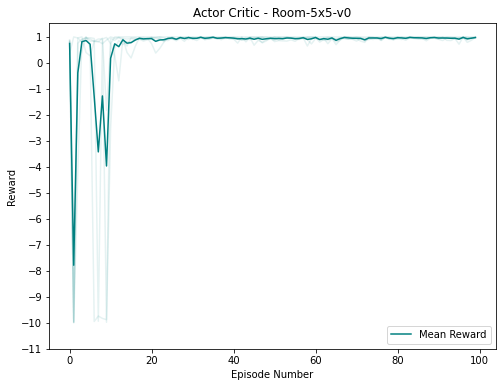

In [37]:
plot_results(env_name="Room-5x5-v0",scores=room_5x5_scores, ylim =(-11,2), color = "teal" )

## 4.2 Skill Acquisition - Eat 

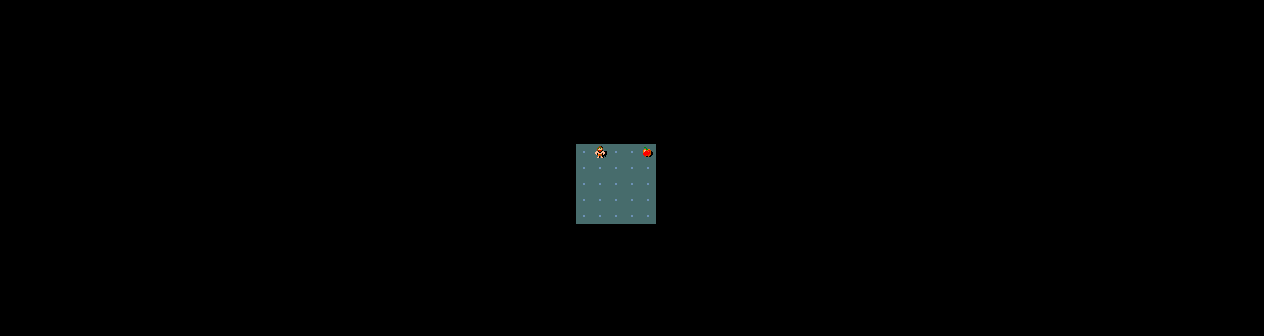

In [31]:
# By default Skill Acquisition tasks have an action space consisting of the full 78 actions available 
# Because most of these actions are unnecessary for smaller tasks we restrict the action space to the necessary 
# actions necesssary to complete the task in each environment only 
MOVE_ACTIONS = tuple(nethack.CompassDirection) # These are the cardinal directions
EAT_ACTIONS = MOVE_ACTIONS + (nethack.Command.EAT,) # Eat is to complete an episode by confirmation 


# Create the environment with the restricted action space as well as
# the observations keys required as input to the Actor Critic Neural Network 
env = gym.make("MiniHack-Eat-v0", observation_keys=["glyphs","pixel","message"],
               actions = EAT_ACTIONS, max_episode_steps=1000)
 
# Reset the environment and display the screen of the starting state 
display_screen(env.reset())

In [32]:
# For skills acquisition tasks more training is required so not only are the episodes longer 
# but the number of episodes is also increased from 100 to 1000 
eat_scores = run_actor_critic(env,number_episodes=250,max_episode_length=1000,iterations=5)

Episode: 0 Reward: -3.6000000000000005 Average Reward: -3.6000000000000005 Steps 999


/opt/homebrew/Caskroom/miniforge/base/envs/minihack/lib/python3.9/site-packages/torch/_tensor.py:493: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Episode: 1 Reward: -9.989999999999998 Average Reward: -6.795 Steps 999
Episode: 2 Reward: -1.5500000000000003 Average Reward: -5.046666666666667 Steps 599
Episode: 3 Reward: -6.27 Average Reward: -5.3525 Steps 999
Episode: 4 Reward: 0.2800000000000001 Average Reward: -4.226 Steps 184
Episode: 5 Reward: 0.51 Average Reward: -3.436666666666666 Steps 180
Episode: 6 Reward: 0.94 Average Reward: -2.811428571428571 Steps 14
Episode: 7 Reward: 0.89 Average Reward: -2.34875 Steps 13
Episode: 8 Reward: -3.61 Average Reward: -2.488888888888889 Steps 999
Episode: 9 Reward: 0.94 Average Reward: -2.146 Steps 11
Episode: 10 Reward: 0.3799999999999999 Average Reward: -1.9163636363636363 Steps 186
Episode: 11 Reward: -4.5 Average Reward: -2.1316666666666664 Steps 999
Episode: 12 Reward: -0.6800000000000002 Average Reward: -2.02 Steps 463
Episode: 13 Reward: 0.29999999999999993 Average Reward: -1.854285714285714 Steps 134
Episode: 14 Reward: 0.08999999999999997 Average Reward: -1.7246666666666666 Steps

Episode: 105 Reward: 0.57 Average Reward: -0.09860000000000005 Steps 105
Episode: 106 Reward: 0.94 Average Reward: -0.07620000000000003 Steps 18
Episode: 107 Reward: 0.3299999999999999 Average Reward: -0.06160000000000003 Steps 138
Episode: 108 Reward: -0.2900000000000001 Average Reward: -0.07860000000000006 Steps 310
Episode: 109 Reward: -0.88 Average Reward: -0.10480000000000005 Steps 503
Episode: 110 Reward: -1.6500000000000004 Average Reward: -0.14220000000000005 Steps 656
Episode: 111 Reward: -0.30000000000000004 Average Reward: -0.16420000000000004 Steps 362
Episode: 112 Reward: 0.66 Average Reward: -0.13360000000000002 Steps 83
Episode: 113 Reward: 0.48999999999999994 Average Reward: -0.13140000000000004 Steps 131
Episode: 114 Reward: 0.78 Average Reward: -0.134 Steps 61
Episode: 115 Reward: 0.1499999999999998 Average Reward: -0.13900000000000007 Steps 168
Episode: 116 Reward: -3.93 Average Reward: -0.22020000000000006 Steps 999
Episode: 117 Reward: 0.55 Average Reward: -0.22260

Episode: 210 Reward: -0.8300000000000001 Average Reward: -0.1382000000000001 Steps 385
Episode: 211 Reward: 0.33999999999999997 Average Reward: -0.1022000000000001 Steps 139
Episode: 212 Reward: 0.8 Average Reward: 0.005799999999999919 Steps 53
Episode: 213 Reward: 0.2799999999999999 Average Reward: -0.0024000000000000753 Steps 162
Episode: 214 Reward: 0.9 Average Reward: -0.0020000000000000885 Steps 34
Episode: 215 Reward: 0.16999999999999993 Average Reward: 0.08539999999999992 Steps 173
Episode: 216 Reward: -0.5200000000000001 Average Reward: 0.0905999999999999 Steps 366
Episode: 217 Reward: -0.91 Average Reward: 0.10559999999999992 Steps 454
Episode: 218 Reward: 0.52 Average Reward: 0.0961999999999999 Steps 145
Episode: 219 Reward: 0.010000000000000009 Average Reward: 0.08879999999999992 Steps 217
Episode: 220 Reward: 0.32 Average Reward: 0.10079999999999993 Steps 159
Episode: 221 Reward: -2.29 Average Reward: 0.04059999999999995 Steps 777
Episode: 222 Reward: 0.2799999999999999 Ave

Episode: 67 Reward: 0.4099999999999999 Average Reward: -0.20520000000000013 Steps 114
Episode: 68 Reward: 0.85 Average Reward: -0.1258000000000001 Steps 29
Episode: 69 Reward: 0.59 Average Reward: -0.04140000000000008 Steps 76
Episode: 70 Reward: 0.63 Average Reward: -0.04560000000000009 Steps 68
Episode: 71 Reward: 0.47 Average Reward: -0.05220000000000006 Steps 102
Episode: 72 Reward: -0.18000000000000005 Average Reward: -0.026000000000000075 Steps 234
Episode: 73 Reward: 0.029999999999999916 Average Reward: -0.044800000000000055 Steps 241
Episode: 74 Reward: -0.6900000000000001 Average Reward: -0.07620000000000005 Steps 309
Episode: 75 Reward: 0.6799999999999999 Average Reward: -0.06460000000000003 Steps 47
Episode: 76 Reward: -0.15000000000000002 Average Reward: -0.04260000000000004 Steps 242
Episode: 77 Reward: -5.55 Average Reward: -0.17040000000000002 Steps 999
Episode: 78 Reward: -3.4500000000000006 Average Reward: -0.25400000000000006 Steps 603
Episode: 79 Reward: -7.27 Averag

Episode: 183 Reward: 0.6199999999999999 Average Reward: 0.7544 Steps 92
Episode: 184 Reward: 0.86 Average Reward: 0.7589999999999999 Steps 38
Episode: 185 Reward: 0.96 Average Reward: 0.7696 Steps 14
Episode: 186 Reward: 0.040000000000000036 Average Reward: 0.7602 Steps 184
Episode: 187 Reward: 0.9 Average Reward: 0.7697999999999999 Steps 33
Episode: 188 Reward: 0.94 Average Reward: 0.7755999999999998 Steps 17
Episode: 189 Reward: 0.64 Average Reward: 0.7689999999999999 Steps 105
Episode: 190 Reward: 0.95 Average Reward: 0.7698 Steps 17
Episode: 191 Reward: 0.98 Average Reward: 0.7706000000000001 Steps 6
Episode: 192 Reward: 0.95 Average Reward: 0.77 Steps 10
Episode: 193 Reward: 0.97 Average Reward: 0.7753999999999999 Steps 10
Episode: 194 Reward: 0.4599999999999999 Average Reward: 0.7764 Steps 183
Episode: 195 Reward: 0.6 Average Reward: 0.7686000000000002 Steps 105
Episode: 196 Reward: 0.7 Average Reward: 0.7676000000000001 Steps 87
Episode: 197 Reward: 0.95 Average Reward: 0.770200

Episode: 47 Reward: -2.9400000000000004 Average Reward: -0.6352083333333335 Steps 919
Episode: 48 Reward: 0.6699999999999999 Average Reward: -0.6085714285714288 Steps 106
Episode: 49 Reward: -0.45000000000000007 Average Reward: -0.6054000000000002 Steps 383
Episode: 50 Reward: -0.25000000000000006 Average Reward: -0.6224000000000001 Steps 344
Episode: 51 Reward: 0.44999999999999984 Average Reward: -0.41380000000000017 Steps 120
Episode: 52 Reward: -0.51 Average Reward: -0.3410000000000001 Steps 358
Episode: 53 Reward: 0.97 Average Reward: -0.2878000000000001 Steps 19
Episode: 54 Reward: -0.56 Average Reward: -0.2240000000000001 Steps 421
Episode: 55 Reward: 0.97 Average Reward: -0.2202000000000001 Steps 8
Episode: 56 Reward: 0.44999999999999996 Average Reward: -0.21140000000000012 Steps 126
Episode: 57 Reward: 0.27999999999999997 Average Reward: -0.20200000000000012 Steps 166
Episode: 58 Reward: 0.47 Average Reward: -0.1964000000000001 Steps 126
Episode: 59 Reward: -0.03000000000000008

Episode: 149 Reward: 0.51 Average Reward: -0.2280000000000001 Steps 106
Episode: 150 Reward: 0.96 Average Reward: -0.20120000000000005 Steps 12
Episode: 151 Reward: -0.01000000000000012 Average Reward: -0.20879999999999999 Steps 290
Episode: 152 Reward: -1.1400000000000001 Average Reward: -0.14740000000000006 Steps 566
Episode: 153 Reward: -0.52 Average Reward: -0.16440000000000002 Steps 390
Episode: 154 Reward: 0.9299999999999999 Average Reward: -0.16000000000000003 Steps 15
Episode: 155 Reward: 0.61 Average Reward: -0.1388 Steps 60
Episode: 156 Reward: 0.66 Average Reward: -0.13600000000000004 Steps 65
Episode: 157 Reward: 0.79 Average Reward: -0.10420000000000003 Steps 43
Episode: 158 Reward: -3.9000000000000004 Average Reward: -0.09960000000000002 Steps 999
Episode: 159 Reward: 0.76 Average Reward: -0.09520000000000003 Steps 62
Episode: 160 Reward: -1.7300000000000002 Average Reward: -0.14080000000000006 Steps 704
Episode: 161 Reward: 0.84 Average Reward: -0.13440000000000002 Steps

Episode: 4 Reward: 0.3699999999999999 Average Reward: -1.802 Steps 141
Episode: 5 Reward: -7.009999999999999 Average Reward: -2.67 Steps 999
Episode: 6 Reward: -1.58 Average Reward: -2.5142857142857147 Steps 571
Episode: 7 Reward: 0.38999999999999996 Average Reward: -2.1512499999999997 Steps 186
Episode: 8 Reward: 0.6799999999999999 Average Reward: -1.8366666666666664 Steps 60
Episode: 9 Reward: 0.9299999999999999 Average Reward: -1.5599999999999998 Steps 14
Episode: 10 Reward: 0.71 Average Reward: -1.3536363636363633 Steps 67
Episode: 11 Reward: -0.5900000000000002 Average Reward: -1.2899999999999998 Steps 381
Episode: 12 Reward: 0.9 Average Reward: -1.1215384615384614 Steps 20
Episode: 13 Reward: -0.14 Average Reward: -1.0514285714285712 Steps 239
Episode: 14 Reward: -0.040000000000000036 Average Reward: -0.9839999999999999 Steps 181
Episode: 15 Reward: -2.2 Average Reward: -1.06 Steps 645
Episode: 16 Reward: 0.64 Average Reward: -0.96 Steps 57
Episode: 17 Reward: 0.13999999999999996

Episode: 113 Reward: 0.19999999999999996 Average Reward: 0.003399999999999965 Steps 143
Episode: 114 Reward: -0.04000000000000015 Average Reward: 0.03299999999999996 Steps 219
Episode: 115 Reward: 0.77 Average Reward: 0.028799999999999954 Steps 53
Episode: 116 Reward: 0.30000000000000004 Average Reward: 0.02279999999999996 Steps 114
Episode: 117 Reward: 0.7799999999999999 Average Reward: 0.020799999999999964 Steps 40
Episode: 118 Reward: -0.8200000000000001 Average Reward: -0.002800000000000036 Steps 354
Episode: 119 Reward: -2.0 Average Reward: -0.04500000000000003 Steps 641
Episode: 120 Reward: 0.1999999999999999 Average Reward: -0.05140000000000004 Steps 180
Episode: 121 Reward: 0.97 Average Reward: -0.04220000000000004 Steps 9
Episode: 122 Reward: 0.98 Average Reward: -0.04000000000000004 Steps 7
Episode: 123 Reward: 0.98 Average Reward: -0.039200000000000026 Steps 3
Episode: 124 Reward: 0.62 Average Reward: -0.02200000000000003 Steps 81
Episode: 125 Reward: 0.8 Average Reward: 0.0

Episode: 230 Reward: 0.63 Average Reward: 0.807 Steps 142
Episode: 231 Reward: 0.94 Average Reward: 0.8126000000000001 Steps 30
Episode: 232 Reward: 0.83 Average Reward: 0.8097999999999999 Steps 38
Episode: 233 Reward: 0.88 Average Reward: 0.8104 Steps 57
Episode: 234 Reward: 0.95 Average Reward: 0.8100000000000002 Steps 17
Episode: 235 Reward: 0.76 Average Reward: 0.8132 Steps 61
Episode: 236 Reward: 0.58 Average Reward: 0.8093999999999998 Steps 100
Episode: 237 Reward: 0.97 Average Reward: 0.8135999999999999 Steps 12
Episode: 238 Reward: 0.92 Average Reward: 0.818 Steps 20
Episode: 239 Reward: 0.67 Average Reward: 0.8132 Steps 105
Episode: 240 Reward: 0.97 Average Reward: 0.8166 Steps 19
Episode: 241 Reward: 0.43 Average Reward: 0.8088 Steps 158
Episode: 242 Reward: 0.9 Average Reward: 0.8073999999999998 Steps 37
Episode: 243 Reward: 0.89 Average Reward: 0.8083999999999999 Steps 37
Episode: 244 Reward: 0.88 Average Reward: 0.807 Steps 46
Episode: 245 Reward: 0.88 Average Reward: 0.80

Episode: 90 Reward: -0.8800000000000001 Average Reward: 0.09559999999999994 Steps 406
Episode: 91 Reward: 0.35 Average Reward: 0.08659999999999998 Steps 162
Episode: 92 Reward: 0.99 Average Reward: 0.10119999999999992 Steps 4
Episode: 93 Reward: -0.26 Average Reward: 0.09299999999999997 Steps 270
Episode: 94 Reward: 0.88 Average Reward: 0.10439999999999994 Steps 48
Episode: 95 Reward: 0.1299999999999999 Average Reward: 0.12539999999999998 Steps 200
Episode: 96 Reward: -0.22000000000000008 Average Reward: 0.12799999999999995 Steps 321
Episode: 97 Reward: -3.13 Average Reward: 0.06179999999999996 Steps 963
Episode: 98 Reward: -4.29 Average Reward: -0.04140000000000006 Steps 999
Episode: 99 Reward: -0.2100000000000002 Average Reward: -0.05640000000000006 Steps 271
Episode: 100 Reward: 0.76 Average Reward: -0.05720000000000008 Steps 61
Episode: 101 Reward: 0.8200000000000001 Average Reward: -0.008800000000000044 Steps 41
Episode: 102 Reward: 0.88 Average Reward: 0.03319999999999992 Steps 5

Episode: 193 Reward: 0.9 Average Reward: 0.09139999999999995 Steps 26
Episode: 194 Reward: 0.45999999999999996 Average Reward: 0.08719999999999992 Steps 117
Episode: 195 Reward: -0.66 Average Reward: 0.06519999999999992 Steps 419
Episode: 196 Reward: 0.64 Average Reward: 0.060199999999999934 Steps 113
Episode: 197 Reward: 0.93 Average Reward: 0.07119999999999993 Steps 10
Episode: 198 Reward: 0.97 Average Reward: 0.16699999999999995 Steps 6
Episode: 199 Reward: 0.89 Average Reward: 0.17699999999999994 Steps 44
Episode: 200 Reward: 0.5299999999999999 Average Reward: 0.17999999999999994 Steps 113
Episode: 201 Reward: 0.33999999999999986 Average Reward: 0.17979999999999993 Steps 205
Episode: 202 Reward: 0.29999999999999993 Average Reward: 0.19659999999999997 Steps 205
Episode: 203 Reward: 0.06999999999999995 Average Reward: 0.18039999999999995 Steps 206
Episode: 204 Reward: 0.89 Average Reward: 0.2104 Steps 31
Episode: 205 Reward: 0.59 Average Reward: 0.21999999999999997 Steps 108
Episode:

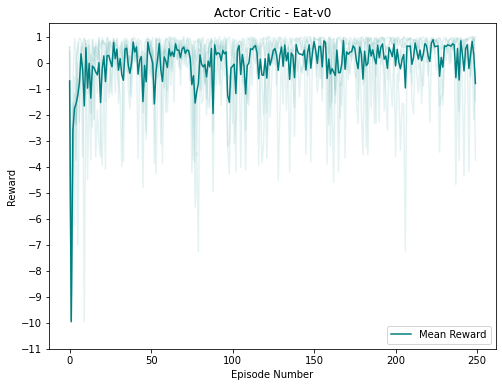

In [38]:
plot_results(env_name="Eat-v0",scores=eat_scores,  ylim= (-11,2),color = "teal")

## 3. Quest Hard 

In [45]:
# Restricting the action space
QUEST_ACTIONS = (
    nethack.CompassDirection.N,
    nethack.CompassDirection.E,
    nethack.CompassDirection.S,
    nethack.CompassDirection.W,
    nethack.CompassDirection.NW,
    nethack.Command.PICKUP,
    nethack.Command.APPLY,
    nethack.Command.FIRE,
    nethack.Command.RUSH,
    nethack.Command.ZAP, 
    nethack.Command.PUTON,
    nethack.Command.READ,
    nethack.Command.WEAR,
    nethack.Command.QUAFF
)

In [46]:
# Custom Reward for exploring more of the map 
def maze_explore_reward(env, prev_obs, action, next_obs):
    if (prev_obs[0] == 2359).sum() > (next_obs[0] == 2359).sum():
        return 0.1
    return 0

In [47]:
# Reward Manager for including custom rewards
from minihack import RewardManager

reward_gen = RewardManager()

# Random reward included to prevent reward glitch 
reward_gen.add_eat_event("apple", reward=1)

# Custom Rewards for long corridors at top and bottom 
reward_gen.add_coordinate_event((3,27), reward = -5, terminal_required = False)
reward_gen.add_coordinate_event((3,28), reward = -5, terminal_required = False)
reward_gen.add_coordinate_event((3,29), reward = -5, terminal_required = False)

reward_gen.add_coordinate_event((19,27), reward = -5, terminal_required = False)
reward_gen.add_coordinate_event((19,28), reward = -5, terminal_required = False)
reward_gen.add_coordinate_event((19,29), reward = -5, terminal_required = False)

reward_gen.add_coordinate_event((11,27), reward = 100, terminal_required = False)# first door at end of maze
reward_gen.add_custom_reward_fn(maze_explore_reward)

In [32]:
env = gym.make("MiniHack-Quest-Hard-v0", reward_manager = reward_gen, actions = QUEST_ACTIONS)

quest_hard_exp_scores = run_actor_critic(env, number_episodes = 500, max_episode_length = 1000,iterations = 5)

Episode: 0 Reward: -7.459999999999999 Average Reward: -7.459999999999999 Steps 999


/home/thishen/.local/lib/python3.8/site-packages/torch/tensor.py:447: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/tmp/ipykernel_2817/61882409.py:83: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.smooth_l1_loss(value, reward)


Episode: 1 Reward: -9.989999999999998 Average Reward: -8.724999999999998 Steps 999
Episode: 2 Reward: -5.35 Average Reward: -7.599999999999999 Steps 999
Episode: 3 Reward: -8.87 Average Reward: -7.917499999999999 Steps 999
Episode: 4 Reward: -9.989999999999998 Average Reward: -8.331999999999999 Steps 999
Episode: 5 Reward: -7.609999999999999 Average Reward: -8.211666666666666 Steps 999
Episode: 6 Reward: -5.72 Average Reward: -7.855714285714285 Steps 999
Episode: 7 Reward: -6.219999999999999 Average Reward: -7.651249999999999 Steps 999
Episode: 8 Reward: -6.92 Average Reward: -7.569999999999999 Steps 999
Episode: 9 Reward: -6.359999999999999 Average Reward: -7.449 Steps 999
Episode: 10 Reward: -7.509999999999999 Average Reward: -7.454545454545454 Steps 999
Episode: 11 Reward: -7.739999999999998 Average Reward: -7.478333333333333 Steps 999
Episode: 12 Reward: -6.819999999999999 Average Reward: -7.427692307692307 Steps 999
Episode: 13 Reward: -6.249999999999999 Average Reward: -7.3435714

Episode: 109 Reward: -4.16 Average Reward: -5.0648 Steps 999
Episode: 110 Reward: -4.43 Average Reward: -5.091599999999999 Steps 999
Episode: 111 Reward: -4.68 Average Reward: -5.0624 Steps 999
Episode: 112 Reward: -3.33 Average Reward: -5.032 Steps 999
Episode: 113 Reward: -6.84 Average Reward: -5.0288 Steps 999
Episode: 114 Reward: -4.06 Average Reward: -5.0044 Steps 999
Episode: 115 Reward: -1.0899999999999996 Average Reward: -4.889399999999999 Steps 999
Episode: 116 Reward: -4.67 Average Reward: -4.849799999999999 Steps 999
Episode: 117 Reward: -2.5999999999999996 Average Reward: -4.801399999999998 Steps 999
Episode: 118 Reward: -2.59 Average Reward: -4.7394 Steps 999
Episode: 119 Reward: -4.609999999999999 Average Reward: -4.729399999999999 Steps 999
Episode: 120 Reward: -5.1899999999999995 Average Reward: -4.72 Steps 999
Episode: 121 Reward: -3.8099999999999996 Average Reward: -4.6704 Steps 999
Episode: 122 Reward: -3.6399999999999997 Average Reward: -4.642199999999999 Steps 999


Episode: 225 Reward: -3.4699999999999998 Average Reward: -3.5426000000000006 Steps 999
Episode: 226 Reward: -3.73 Average Reward: -3.517 Steps 999
Episode: 227 Reward: -3.0999999999999996 Average Reward: -3.4730000000000003 Steps 999
Episode: 228 Reward: -3.53 Average Reward: -3.4494000000000007 Steps 999
Episode: 229 Reward: -6.109999999999999 Average Reward: -3.4720000000000004 Steps 999
Episode: 230 Reward: -2.55 Average Reward: -3.429 Steps 999
Episode: 231 Reward: -3.5699999999999994 Average Reward: -3.4008000000000003 Steps 999
Episode: 232 Reward: -2.93 Average Reward: -3.3888 Steps 999
Episode: 233 Reward: -3.0 Average Reward: -3.4158000000000004 Steps 999
Episode: 234 Reward: -1.67 Average Reward: -3.3637999999999995 Steps 999
Episode: 235 Reward: -4.42 Average Reward: -3.3585999999999996 Steps 999
Episode: 236 Reward: -2.38 Average Reward: -3.3522 Steps 999
Episode: 237 Reward: -3.1799999999999997 Average Reward: -3.3276 Steps 999
Episode: 238 Reward: -2.41 Average Reward: -3

Episode: 339 Reward: -4.119999999999999 Average Reward: -2.9684 Steps 999
Episode: 340 Reward: -3.99 Average Reward: -2.9951999999999996 Steps 999
Episode: 341 Reward: -3.3499999999999996 Average Reward: -2.9944 Steps 999
Episode: 342 Reward: -3.9000000000000004 Average Reward: -3.0134 Steps 999
Episode: 343 Reward: -0.5599999999999999 Average Reward: -2.9416 Steps 999
Episode: 344 Reward: -1.43 Average Reward: -2.9128000000000003 Steps 999
Episode: 345 Reward: -1.44 Average Reward: -2.8646000000000003 Steps 999
Episode: 346 Reward: -3.2600000000000002 Average Reward: -2.8705999999999996 Steps 999
Episode: 347 Reward: -2.6099999999999994 Average Reward: -2.8779999999999997 Steps 999
Episode: 348 Reward: -1.5300000000000002 Average Reward: -2.8594 Steps 999
Episode: 349 Reward: -3.82 Average Reward: -2.8694 Steps 999
Episode: 350 Reward: -4.33 Average Reward: -2.9112000000000005 Steps 999
Episode: 351 Reward: -2.1199999999999997 Average Reward: -2.8828000000000005 Steps 999
Episode: 352

Episode: 449 Reward: -1.25 Average Reward: -3.025 Steps 999
Episode: 450 Reward: -4.15 Average Reward: -3.0286 Steps 999
Episode: 451 Reward: -4.609999999999999 Average Reward: -3.0646000000000004 Steps 999
Episode: 452 Reward: -4.18 Average Reward: -3.085200000000001 Steps 999
Episode: 453 Reward: -3.19 Average Reward: -3.0852 Steps 999
Episode: 454 Reward: -1.7800000000000002 Average Reward: -3.0614000000000003 Steps 999
Episode: 455 Reward: -4.459999999999999 Average Reward: -3.0894 Steps 999
Episode: 456 Reward: 0.74 Average Reward: -3.0562 Steps 999
Episode: 457 Reward: -2.87 Average Reward: -3.0574 Steps 999
Episode: 458 Reward: -3.69 Average Reward: -3.0492000000000004 Steps 999
Episode: 459 Reward: -2.1000000000000005 Average Reward: -3.0213999999999994 Steps 999
Episode: 460 Reward: -4.01 Average Reward: -3.0233999999999996 Steps 999
Episode: 461 Reward: -3.02 Average Reward: -3.0206 Steps 999
Episode: 462 Reward: -2.57 Average Reward: -3.0012 Steps 999
Episode: 463 Reward: -2

Episode: 61 Reward: -4.81 Average Reward: -5.1876 Steps 999
Episode: 62 Reward: -6.029999999999999 Average Reward: -5.180599999999999 Steps 999
Episode: 63 Reward: -5.54 Average Reward: -5.1636 Steps 999
Episode: 64 Reward: -4.949999999999999 Average Reward: -5.1518 Steps 999
Episode: 65 Reward: -4.9399999999999995 Average Reward: -5.134399999999999 Steps 999
Episode: 66 Reward: -5.85 Average Reward: -5.129 Steps 999
Episode: 67 Reward: -3.8099999999999996 Average Reward: -5.084199999999999 Steps 999
Episode: 68 Reward: -3.42 Average Reward: -5.0428 Steps 999
Episode: 69 Reward: -2.86 Average Reward: -4.9342 Steps 999
Episode: 70 Reward: -5.989999999999999 Average Reward: -4.9398 Steps 999
Episode: 71 Reward: -3.7300000000000004 Average Reward: -4.8942 Steps 999
Episode: 72 Reward: -5.4799999999999995 Average Reward: -4.954999999999999 Steps 999
Episode: 73 Reward: -3.6599999999999997 Average Reward: -4.905799999999999 Steps 999
Episode: 74 Reward: -5.109999999999999 Average Reward: -4

Episode: 175 Reward: -3.1100000000000003 Average Reward: -4.446200000000001 Steps 999
Episode: 176 Reward: -3.6899999999999995 Average Reward: -4.4182 Steps 999
Episode: 177 Reward: -4.62 Average Reward: -4.4348 Steps 999
Episode: 178 Reward: -3.4399999999999995 Average Reward: -4.4246 Steps 999
Episode: 179 Reward: -4.620000000000001 Average Reward: -4.4062 Steps 999
Episode: 180 Reward: -1.4899999999999998 Average Reward: -4.3164 Steps 999
Episode: 181 Reward: -3.3099999999999996 Average Reward: -4.285399999999999 Steps 999
Episode: 182 Reward: -4.119999999999999 Average Reward: -4.2936000000000005 Steps 999
Episode: 183 Reward: -3.59 Average Reward: -4.2836 Steps 999
Episode: 184 Reward: -3.05 Average Reward: -4.2282 Steps 999
Episode: 185 Reward: -3.34 Average Reward: -4.1948 Steps 999
Episode: 186 Reward: -5.909999999999999 Average Reward: -4.2142 Steps 999
Episode: 187 Reward: -3.95 Average Reward: -4.2059999999999995 Steps 999
Episode: 188 Reward: -5.219999999999999 Average Rewa

Episode: 289 Reward: -3.4599999999999995 Average Reward: -3.3680000000000008 Steps 999
Episode: 290 Reward: -5.529999999999999 Average Reward: -3.5056 Steps 999
Episode: 291 Reward: -4.9399999999999995 Average Reward: -3.557 Steps 999
Episode: 292 Reward: -3.92 Average Reward: -3.5334 Steps 999
Episode: 293 Reward: -6.93 Average Reward: -3.5144 Steps 999
Episode: 294 Reward: -2.3000000000000003 Average Reward: -3.5028 Steps 999
Episode: 295 Reward: -4.64 Average Reward: -3.4928 Steps 999
Episode: 296 Reward: -4.04 Average Reward: -3.4671999999999996 Steps 999
Episode: 297 Reward: -2.6500000000000004 Average Reward: -3.4452 Steps 999
Episode: 298 Reward: -4.86 Average Reward: -3.4526000000000003 Steps 999
Episode: 299 Reward: -3.29 Average Reward: -3.4444 Steps 999
Episode: 300 Reward: -3.4499999999999997 Average Reward: -3.4323999999999995 Steps 999
Episode: 301 Reward: -5.549999999999999 Average Reward: -3.4424 Steps 999
Episode: 302 Reward: -0.9400000000000005 Average Reward: -3.3798

Episode: 402 Reward: -4.3100000000000005 Average Reward: -3.7207999999999997 Steps 999
Episode: 403 Reward: -2.6100000000000003 Average Reward: -3.6660000000000004 Steps 999
Episode: 404 Reward: -3.37 Average Reward: -3.6614 Steps 999
Episode: 405 Reward: -1.2300000000000002 Average Reward: -3.5980000000000003 Steps 999
Episode: 406 Reward: -3.66 Average Reward: -3.6113999999999997 Steps 999
Episode: 407 Reward: -3.1799999999999997 Average Reward: -3.6126000000000005 Steps 999
Episode: 408 Reward: -2.75 Average Reward: -3.5326 Steps 999
Episode: 409 Reward: -2.8200000000000003 Average Reward: -3.4956 Steps 999
Episode: 410 Reward: -2.0999999999999996 Average Reward: -3.4532 Steps 999
Episode: 411 Reward: -1.7299999999999998 Average Reward: -3.3914 Steps 999
Episode: 412 Reward: -3.2800000000000002 Average Reward: -3.4095999999999997 Steps 999
Episode: 413 Reward: -2.14 Average Reward: -3.3756 Steps 999
Episode: 414 Reward: -3.1599999999999997 Average Reward: -3.3737999999999992 Steps 9

Episode: 11 Reward: -8.45 Average Reward: -8.795833333333333 Steps 999
Episode: 12 Reward: -9.57 Average Reward: -8.855384615384613 Steps 999
Episode: 13 Reward: -7.91 Average Reward: -8.78785714285714 Steps 999
Episode: 14 Reward: -9.219999999999999 Average Reward: -8.816666666666665 Steps 999
Episode: 15 Reward: -8.95 Average Reward: -8.825 Steps 999
Episode: 16 Reward: -7.4 Average Reward: -8.741176470588234 Steps 999
Episode: 17 Reward: -9.04 Average Reward: -8.757777777777777 Steps 999
Episode: 18 Reward: -7.139999999999999 Average Reward: -8.672631578947367 Steps 999
Episode: 19 Reward: -9.129999999999999 Average Reward: -8.6955 Steps 999
Episode: 20 Reward: -8.95 Average Reward: -8.707619047619046 Steps 999
Episode: 21 Reward: -6.789999999999999 Average Reward: -8.620454545454542 Steps 999
Episode: 22 Reward: -7.66 Average Reward: -8.578695652173911 Steps 999
Episode: 23 Reward: -7.339999999999999 Average Reward: -8.527083333333332 Steps 999
Episode: 24 Reward: -7.31999999999999

Episode: 121 Reward: -3.53 Average Reward: -4.865 Steps 999
Episode: 122 Reward: -4.04 Average Reward: -4.844799999999999 Steps 999
Episode: 123 Reward: -4.46 Average Reward: -4.7384 Steps 999
Episode: 124 Reward: -3.58 Average Reward: -4.687799999999999 Steps 999
Episode: 125 Reward: -3.12 Average Reward: -4.6692 Steps 999
Episode: 126 Reward: -2.0 Average Reward: -4.6348 Steps 999
Episode: 127 Reward: -1.2999999999999998 Average Reward: -4.5528 Steps 999
Episode: 128 Reward: -4.72 Average Reward: -4.5494 Steps 999
Episode: 129 Reward: -4.56 Average Reward: -4.558599999999999 Steps 999
Episode: 130 Reward: -3.4 Average Reward: -4.5076 Steps 999
Episode: 131 Reward: -3.5799999999999996 Average Reward: -4.450400000000001 Steps 999
Episode: 132 Reward: -4.54 Average Reward: -4.343999999999999 Steps 999
Episode: 133 Reward: -3.12 Average Reward: -4.273599999999999 Steps 999
Episode: 134 Reward: -2.67 Average Reward: -4.1758 Steps 999
Episode: 135 Reward: -1.4 Average Reward: -4.0604 Steps

Episode: 234 Reward: -2.34 Average Reward: -3.461 Steps 999
Episode: 235 Reward: -4.13 Average Reward: -3.4613999999999994 Steps 999
Episode: 236 Reward: -4.33 Average Reward: -3.4663999999999997 Steps 999
Episode: 237 Reward: -0.5800000000000003 Average Reward: -3.3968000000000007 Steps 999
Episode: 238 Reward: -0.9100000000000001 Average Reward: -3.414399999999999 Steps 999
Episode: 239 Reward: -2.4099999999999997 Average Reward: -3.284 Steps 999
Episode: 240 Reward: -3.7 Average Reward: -3.2801999999999993 Steps 999
Episode: 241 Reward: -7.42 Average Reward: -3.3819999999999997 Steps 999
Episode: 242 Reward: -2.23 Average Reward: -3.363599999999999 Steps 999
Episode: 243 Reward: -3.9899999999999998 Average Reward: -3.4271999999999996 Steps 999
Episode: 244 Reward: -3.51 Average Reward: -3.4848000000000003 Steps 999
Episode: 245 Reward: -4.279999999999999 Average Reward: -3.5044 Steps 999
Episode: 246 Reward: -3.55 Average Reward: -3.5596000000000005 Steps 999
Episode: 247 Reward: -3

Episode: 345 Reward: -3.84 Average Reward: -3.3755999999999995 Steps 999
Episode: 346 Reward: -2.38 Average Reward: -3.3562 Steps 999
Episode: 347 Reward: -4.58 Average Reward: -3.3588000000000005 Steps 999
Episode: 348 Reward: -4.61 Average Reward: -3.3896 Steps 999
Episode: 349 Reward: -3.5 Average Reward: -3.3820000000000006 Steps 999
Episode: 350 Reward: -1.9100000000000001 Average Reward: -3.375 Steps 999
Episode: 351 Reward: -2.3499999999999996 Average Reward: -3.3684000000000003 Steps 999
Episode: 352 Reward: -3.0300000000000002 Average Reward: -3.3386 Steps 999
Episode: 353 Reward: -2.9 Average Reward: -3.3054 Steps 999
Episode: 354 Reward: -4.26 Average Reward: -3.3352 Steps 999
Episode: 355 Reward: -1.2599999999999998 Average Reward: -3.2753999999999994 Steps 999
Episode: 356 Reward: -2.83 Average Reward: -3.2344 Steps 999
Episode: 357 Reward: -3.1900000000000004 Average Reward: -3.2182 Steps 999
Episode: 358 Reward: -1.4 Average Reward: -3.1799999999999993 Steps 999
Episode:

Episode: 457 Reward: -2.75 Average Reward: -2.2228 Steps 999
Episode: 458 Reward: -4.3 Average Reward: -2.259 Steps 999
Episode: 459 Reward: -2.25 Average Reward: -2.2725999999999997 Steps 999
Episode: 460 Reward: -2.6799999999999997 Average Reward: -2.19 Steps 999
Episode: 461 Reward: -1.9699999999999998 Average Reward: -2.1756 Steps 999
Episode: 462 Reward: -1.9100000000000001 Average Reward: -2.1795999999999998 Steps 999
Episode: 463 Reward: -4.2 Average Reward: -2.2011999999999996 Steps 999
Episode: 464 Reward: -0.5400000000000005 Average Reward: -2.2004 Steps 999
Episode: 465 Reward: -1.36 Average Reward: -2.1526 Steps 999
Episode: 466 Reward: -2.5000000000000004 Average Reward: -2.1172 Steps 999
Episode: 467 Reward: -1.5899999999999999 Average Reward: -2.135 Steps 999
Episode: 468 Reward: -3.48 Average Reward: -2.1546000000000003 Steps 999
Episode: 469 Reward: -1.0400000000000003 Average Reward: -2.1488 Steps 999
Episode: 470 Reward: -0.7300000000000004 Average Reward: -2.2037999

Episode: 67 Reward: -3.72 Average Reward: -4.657999999999999 Steps 999
Episode: 68 Reward: -3.81 Average Reward: -4.6156 Steps 999
Episode: 69 Reward: -2.5899999999999994 Average Reward: -4.541399999999999 Steps 999
Episode: 70 Reward: -5.779999999999999 Average Reward: -4.565 Steps 999
Episode: 71 Reward: -2.9599999999999995 Average Reward: -4.526 Steps 999
Episode: 72 Reward: -3.46 Average Reward: -4.4916 Steps 999
Episode: 73 Reward: -3.3999999999999995 Average Reward: -4.4468 Steps 999
Episode: 74 Reward: -3.5599999999999996 Average Reward: -4.4156 Steps 999
Episode: 75 Reward: -4.79 Average Reward: -4.3918 Steps 999
Episode: 76 Reward: -4.3999999999999995 Average Reward: -4.3576 Steps 999
Episode: 77 Reward: -3.5799999999999996 Average Reward: -4.3014 Steps 999
Episode: 78 Reward: -1.6299999999999994 Average Reward: -4.220000000000001 Steps 999
Episode: 79 Reward: -3.98 Average Reward: -4.210799999999999 Steps 999
Episode: 80 Reward: -2.2300000000000004 Average Reward: -4.1724 Ste

Episode: 180 Reward: -2.84 Average Reward: -2.5465999999999998 Steps 999
Episode: 181 Reward: -4.49 Average Reward: -2.5848 Steps 999
Episode: 182 Reward: -3.7399999999999993 Average Reward: -2.7116000000000002 Steps 999
Episode: 183 Reward: -3.54 Average Reward: -2.7421999999999995 Steps 999
Episode: 184 Reward: -3.48 Average Reward: -2.7845999999999993 Steps 999
Episode: 185 Reward: -2.44 Average Reward: -2.7878 Steps 999
Episode: 186 Reward: -1.67 Average Reward: -2.727 Steps 999
Episode: 187 Reward: -1.5399999999999996 Average Reward: -2.734 Steps 999
Episode: 188 Reward: -0.8800000000000001 Average Reward: -2.7014 Steps 999
Episode: 189 Reward: -3.3300000000000005 Average Reward: -2.7186000000000003 Steps 999
Episode: 190 Reward: -0.7599999999999998 Average Reward: -2.6684 Steps 999
Episode: 191 Reward: -1.2400000000000002 Average Reward: -2.6141999999999994 Steps 999
Episode: 192 Reward: -1.17 Average Reward: -2.6234 Steps 999
Episode: 193 Reward: -3.0600000000000005 Average Rewa

Episode: 293 Reward: -2.87 Average Reward: -2.1526 Steps 999
Episode: 294 Reward: -2.12 Average Reward: -2.1612 Steps 999
Episode: 295 Reward: -2.2 Average Reward: -2.1910000000000003 Steps 999
Episode: 296 Reward: -3.0700000000000003 Average Reward: -2.1786000000000003 Steps 999
Episode: 297 Reward: -1.6400000000000003 Average Reward: -2.2074 Steps 999
Episode: 298 Reward: 1.08 Average Reward: -2.151 Steps 999
Episode: 299 Reward: -3.86 Average Reward: -2.2438 Steps 999
Episode: 300 Reward: -2.2399999999999998 Average Reward: -2.2672 Steps 999
Episode: 301 Reward: -4.21 Average Reward: -2.3031999999999995 Steps 999
Episode: 302 Reward: -2.54 Average Reward: -2.296 Steps 999
Episode: 303 Reward: -2.37 Average Reward: -2.3078 Steps 999
Episode: 304 Reward: -3.2600000000000002 Average Reward: -2.3404 Steps 999
Episode: 305 Reward: -2.0500000000000003 Average Reward: -2.3356 Steps 999
Episode: 306 Reward: -7.6 Average Reward: -2.4072 Steps 999
Episode: 307 Reward: -0.74 Average Reward: -2

Episode: 409 Reward: -3.4999999999999996 Average Reward: -2.2208 Steps 999
Episode: 410 Reward: -3.46 Average Reward: -2.2556 Steps 999
Episode: 411 Reward: -3.25 Average Reward: -2.2953999999999994 Steps 999
Episode: 412 Reward: -2.71 Average Reward: -2.2669999999999995 Steps 999
Episode: 413 Reward: -2.5700000000000003 Average Reward: -2.2615999999999996 Steps 999
Episode: 414 Reward: -1.33 Average Reward: -2.203 Steps 999
Episode: 415 Reward: -2.6 Average Reward: -2.1739999999999995 Steps 999
Episode: 416 Reward: 1.0600000000000003 Average Reward: -2.1659999999999995 Steps 999
Episode: 417 Reward: -2.9699999999999998 Average Reward: -2.089 Steps 999
Episode: 418 Reward: -2.5100000000000002 Average Reward: -2.0744 Steps 999
Episode: 419 Reward: -3.1799999999999997 Average Reward: -2.1174 Steps 999
Episode: 420 Reward: -4.54 Average Reward: -2.1700000000000004 Steps 999
Episode: 421 Reward: -3.67 Average Reward: -2.189 Steps 999
Episode: 422 Reward: -1.5199999999999998 Average Reward:

Episode: 18 Reward: -7.189999999999999 Average Reward: -7.247894736842104 Steps 999
Episode: 19 Reward: -7.1 Average Reward: -7.240499999999999 Steps 999
Episode: 20 Reward: -6.869999999999999 Average Reward: -7.2228571428571415 Steps 999
Episode: 21 Reward: -7.949999999999999 Average Reward: -7.255909090909089 Steps 999
Episode: 22 Reward: -6.3100000000000005 Average Reward: -7.214782608695651 Steps 999
Episode: 23 Reward: -6.6 Average Reward: -7.189166666666665 Steps 999
Episode: 24 Reward: -6.869999999999999 Average Reward: -7.176399999999998 Steps 999
Episode: 25 Reward: -6.5 Average Reward: -7.150384615384614 Steps 999
Episode: 26 Reward: -5.39 Average Reward: -7.085185185185184 Steps 999
Episode: 27 Reward: -6.239999999999999 Average Reward: -7.054999999999999 Steps 999
Episode: 28 Reward: -8.77 Average Reward: -7.114137931034482 Steps 999
Episode: 29 Reward: -7.799999999999999 Average Reward: -7.137 Steps 999
Episode: 30 Reward: -8.11 Average Reward: -7.168387096774192 Steps 999

Episode: 125 Reward: -8.969999999999999 Average Reward: -5.3774 Steps 999
Episode: 126 Reward: -4.2299999999999995 Average Reward: -5.321400000000001 Steps 999
Episode: 127 Reward: -3.0 Average Reward: -5.2638 Steps 999
Episode: 128 Reward: -3.16 Average Reward: -5.192800000000001 Steps 999
Episode: 129 Reward: -2.7199999999999998 Average Reward: -5.119599999999999 Steps 999
Episode: 130 Reward: -3.8999999999999995 Average Reward: -5.1162 Steps 999
Episode: 131 Reward: -4.59 Average Reward: -5.102799999999999 Steps 999
Episode: 132 Reward: -2.84 Average Reward: -5.074199999999999 Steps 999
Episode: 133 Reward: -2.66 Average Reward: -5.0462 Steps 999
Episode: 134 Reward: -9.459999999999999 Average Reward: -5.1316 Steps 999
Episode: 135 Reward: -6.24 Average Reward: -5.1464 Steps 999
Episode: 136 Reward: -1.17 Average Reward: -5.062799999999999 Steps 999
Episode: 137 Reward: -2.66 Average Reward: -5.0026 Steps 999
Episode: 138 Reward: -4.869999999999999 Average Reward: -4.987 Steps 999
E

Episode: 240 Reward: -3.06 Average Reward: -3.5274 Steps 999
Episode: 241 Reward: -9.95 Average Reward: -3.5291999999999994 Steps 999
Episode: 242 Reward: -6.289999999999999 Average Reward: -3.5868 Steps 999
Episode: 243 Reward: -3.5 Average Reward: -3.4921999999999995 Steps 999
Episode: 244 Reward: -4.09 Average Reward: -3.528 Steps 999
Episode: 245 Reward: -2.3200000000000003 Average Reward: -3.3792 Steps 999
Episode: 246 Reward: -1.6900000000000002 Average Reward: -3.3760000000000003 Steps 999
Episode: 247 Reward: -3.9000000000000004 Average Reward: -3.4348 Steps 999
Episode: 248 Reward: -2.6900000000000004 Average Reward: -3.3812 Steps 999
Episode: 249 Reward: -1.16 Average Reward: -3.3394 Steps 999
Episode: 250 Reward: 1.3900000000000001 Average Reward: -3.2706 Steps 999
Episode: 251 Reward: -2.2600000000000002 Average Reward: -3.2608000000000006 Steps 999
Episode: 252 Reward: -9.79 Average Reward: -3.3875999999999995 Steps 999
Episode: 253 Reward: -9.809999999999999 Average Rewar

Episode: 353 Reward: -2.7 Average Reward: -2.5756 Steps 999
Episode: 354 Reward: -3.8600000000000003 Average Reward: -2.6092 Steps 999
Episode: 355 Reward: -1.9000000000000001 Average Reward: -2.6031999999999997 Steps 999
Episode: 356 Reward: -9.57 Average Reward: -2.7779999999999996 Steps 999
Episode: 357 Reward: -2.02 Average Reward: -2.7632 Steps 999
Episode: 358 Reward: -3.18 Average Reward: -2.7698 Steps 999
Episode: 359 Reward: -1.55 Average Reward: -2.8264 Steps 999
Episode: 360 Reward: -1.44 Average Reward: -2.7132000000000005 Steps 999
Episode: 361 Reward: -8.100000000000001 Average Reward: -2.884 Steps 999
Episode: 362 Reward: -2.46 Average Reward: -2.9036 Steps 999
Episode: 363 Reward: -1.37 Average Reward: -2.7598000000000003 Steps 999
Episode: 364 Reward: 0.04999999999999993 Average Reward: -2.7098 Steps 999
Episode: 365 Reward: -0.9200000000000002 Average Reward: -2.717 Steps 999
Episode: 366 Reward: -0.42999999999999994 Average Reward: -2.6956 Steps 999
Episode: 367 Rewa

Episode: 466 Reward: -2.09 Average Reward: -2.8586 Steps 999
Episode: 467 Reward: -3.8100000000000005 Average Reward: -2.9024 Steps 999
Episode: 468 Reward: -5.05 Average Reward: -2.9594000000000005 Steps 999
Episode: 469 Reward: -3.9699999999999998 Average Reward: -2.996000000000001 Steps 999
Episode: 470 Reward: -1.4500000000000002 Average Reward: -2.9785999999999997 Steps 999
Episode: 471 Reward: -4.140000000000001 Average Reward: -2.8960000000000004 Steps 999
Episode: 472 Reward: -1.8599999999999999 Average Reward: -2.8894000000000006 Steps 999
Episode: 473 Reward: -1.2400000000000002 Average Reward: -2.842800000000001 Steps 999
Episode: 474 Reward: -2.43 Average Reward: -2.8694000000000006 Steps 999
Episode: 475 Reward: -2.56 Average Reward: -2.8764000000000003 Steps 999
Episode: 476 Reward: -2.1 Average Reward: -2.8852 Steps 999
Episode: 477 Reward: -1.5 Average Reward: -2.9018 Steps 999
Episode: 478 Reward: -0.6800000000000002 Average Reward: -2.8312 Steps 999
Episode: 479 Rewar

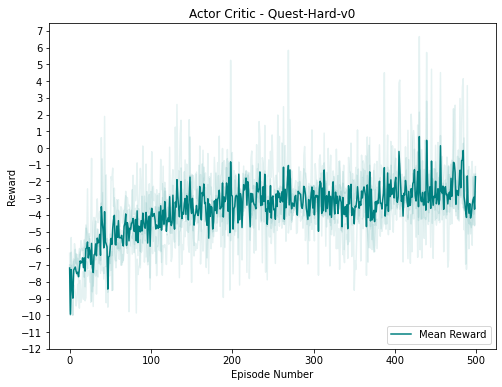

In [70]:
plot_results(env_name="Quest-Hard-v0",scores=quest_hard_exp_scores,ylim=(-12,8), color = "teal" )